# Binary classifier
This notebook contains a binary classifier as a probabilistic model, through which inference is achieved using message passing.

The corresponding probabilistic model is given as

#todo

## Table of content
1. [Data generation](#Data-generation)
2. [Model specification](#Model-specification)
3. [Probabilistic inference](#Probabilistic-inference)
4. [Experimental validation](#Experimental-validation)

In [1]:
using Pkg
Pkg.activate("../..")

using Revise

using Rocket
using ReactiveMP
using GraphPPL

using PyPlot
using Random
using Distributions
using LinearAlgebra
using StatsFuns

 Activating environment at `D:\OneDrive - TU Eindhoven\phd\Projects\AIDA\Project.toml`


## Data generation

In [2]:
function generate_data(nr_samples::Int64)
    """
    Mimic ideal user preferences as some noisy diagonal relation between the weights.
    """
    
    # specify initial distributions
    R(θ) = [cos(θ) -sin(θ); sin(θ) cos(θ)]
#     dist1 = MvNormal([0.8, 0.2], 0.001*R(-pi/4)*[5 0; 0 0.5]*R(-pi/4)')
#     dist2 = MvNormal([0.8; 0.2], 0.01*R(-pi/4)*[5 0; 0 0.5]*R(-pi/4)')
    dist1 = MvNormal([0.8, 0.2], 0.001*R(-pi/4)*[5 0; 0 0.5]*R(-pi/4)')
    dist2 = MvNormal([0.6; 0.2], 0.001*R(-pi/4)*[5 0; 0 0.5]*R(-pi/4)')
    
    # allocate space for data
    data_x = Array{Float64,2}(undef, nr_samples, 2)
    data_y = Array{Int64,1}(undef, nr_samples)
    
    # collect data
    for k = 1:nr_samples
        
        # sample data point at [0,1]^2 
        data_x[k,:] = [rand(), rand()]
        
        # determine pdfs
        prob1 = pdf(dist1, data_x[k,:])
        prob2 = pdf(dist2, data_x[k,:])
        
        # calculate posterior over 1
        post = prob1 / (prob1 + prob2)
        
        # fetch noisy observation
        data_y[k] = rand() < post
        
    end
    
    # return data
    return data_x, data_y
    
end;

In [3]:
data_x, data_y = generate_data(1000);

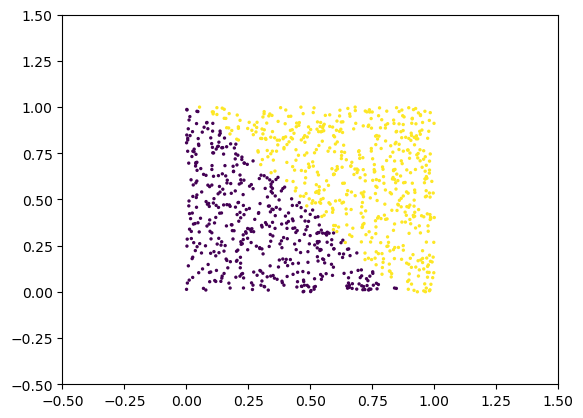

In [4]:
plt.figure()
plt.scatter(data_x[:,1], data_x[:,2], s=2 ,c=data_y)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5);

## Training

### Model specification

In [5]:
@model function binary_classifier(data_x; latent_precision=1e5)
    
    # determine number of samples
    nr_samples = size(data_x,1)
    
    # determine dimensions input
    dim_in = size(data_x,2)

    # allocate space
    output = datavar(Int64, nr_samples)
    w = randomvar()
    z = randomvar(nr_samples)
    f = randomvar(nr_samples)
    x = randomvar(nr_samples)
    y = randomvar(nr_samples)
    yi = randomvar(nr_samples)

    # set priors
    w ~ MvNormalMeanPrecision(randn(dim_in+1), diagm(ones(dim_in+1)))

    # prepare tuples
    wn = tuple(w, )
    zn = Vector{Tuple}(undef, nr_samples)
    fn = Vector{Tuple}(undef, nr_samples)
    
    # create model
    for n = 1:nr_samples
        
        # set priors
        z[n] ~ Bernoulli(0.5)
        f[n] ~ NormalMeanPrecision(1.0, 1e-10)
    
        # latent input
        x[n] ~ MvNormalMeanPrecision(data_x[n,:], diagm(ones(dim_in)*latent_precision))
        
        # DenseReLU node
        zn[n] = tuple(z[n],)
        fn[n] = tuple(f[n],)
        y[n] ~ DenseReLU(x[n], wn, zn[n], fn[n]) where { meta = DenseReLUMeta(1; C=1.0, β=1e0, γ=1e0, use_bias=true), q = MeanField() }
        yi[n] ~ y[n] + (-5) # add offset because of ReLUs
        
        # latent output
        output[n] ~ Probit(yi[n]) where { pipeline=RequireInboundFunctionalDependencies(2, [NormalMeanPrecision(0, 0.001)]) }
        
    end

    # return parameters of interest
    return output, y, x, w, z, f, yi
    
end;

### Probabilistic inference

In [6]:
function inference(data_x, data_y; nr_iterations=10)
    
    # fetch number of samples
    nr_samples = size(data_x, 1)
    
    # determine dimensions input
    dim_in = size(data_x, 2)
    
    # create neural network
    model, (output, y, x, w, z, f, yi) = binary_classifier(data_x);    
    
    # allocate marginals
    mw        = keep(Marginal)
    mz        = buffer(Marginal, nr_samples)
    mf        = buffer(Marginal, nr_samples)
    myi       = buffer(Marginal, nr_samples)
    #fe        = ScoreActor(Float64)

    # subscribe to marginals
    w_sub     = subscribe!(getmarginal(w), mw)
    z_sub     = subscribe!(getmarginals(z), mz)
    f_sub     = subscribe!(getmarginals(f), mf)
    yi_sub    = subscribe!(getmarginals(yi), myi)
    #fe_sub    = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)

    # set initial marginals
    setmarginal!(w, MvNormalMeanPrecision(randn(dim_in+1), diagm(ones(dim_in+1))))
    
    for n = 1:nr_samples
        setmarginal!(x[n], MvNormalMeanPrecision(zeros(dim_in), diagm(ones(dim_in)*1e-10)))
        setmarginal!(y[n], NormalMeanPrecision(0.0, 1e-10))
        setmarginal!(z[n], Bernoulli(0.5))
        setmarginal!(f[n], NormalMeanPrecision(1.0, 1e-10))
    end
    
    # update data
    for i = 1:nr_iterations
        update!(output, data_y)
#         for n = 1:nr_samples
#             update!(output[n], data_y[n])
#         end
    end
    
    # unsubscribe
    unsubscribe!(w_sub)
    unsubscribe!(z_sub)
    unsubscribe!(f_sub)
    unsubscribe!(yi_sub)
    #unsubscribe!(fe_sub)
    
    # return marginals
    return mw, mz, mf, myi#, fe
    
end;

### Training procedure

In [7]:
w, z, f, yi = inference(data_x, data_y; nr_iterations=100);

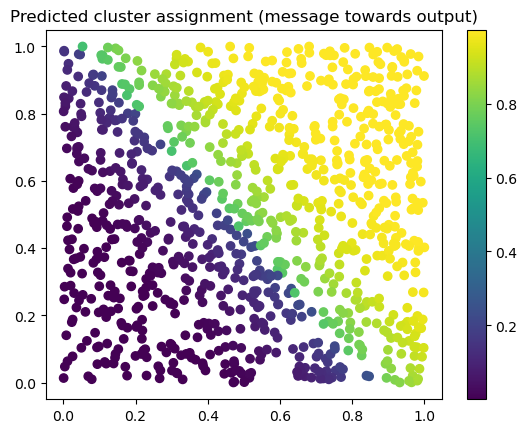

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000626608B0>

In [8]:
plt.figure()
plt.scatter(data_x[:,1], data_x[:,2], c=normcdf.(mean.(yi)./sqrt.(1 .+var.(yi))))
plt.title("Predicted cluster assignment (message towards output)")
plt.colorbar()

## Validation

### Model specification

In [9]:
@model function binary_classifier2(data_x_grid, weights; latent_precision=1e5)
    
    # determine number of samples
    nr_samples = size(data_x_grid,1)
    
    # determine dimensions input
    dim_in = size(data_x_grid,2)

    # allocate space
    input = datavar(Array{Float64,1}, nr_samples)
    output = randomvar(nr_samples)
    w = randomvar()
    z = randomvar(nr_samples)
    f = randomvar(nr_samples)
    x = randomvar(nr_samples)
    y = randomvar(nr_samples)
    yi = randomvar(nr_samples)

    # set priors
    w ~ MvNormalMeanPrecision(mean(weights), precision(weights))

    # prepare tuples
    wn = tuple(w, )
    zn = Vector{Tuple}(undef, nr_samples)
    fn = Vector{Tuple}(undef, nr_samples)
    
    # create model
    for n = 1:nr_samples
        
        # set priors
        z[n] ~ Bernoulli(0.5)
        f[n] ~ NormalMeanPrecision(1.0, 1e-10)
    
        # latent input
        x[n] ~ MvNormalMeanPrecision(input[n], diagm(ones(dim_in)*latent_precision))
        
        # DenseReLU node
        zn[n] = tuple(z[n],)
        fn[n] = tuple(f[n],)
        y[n] ~ DenseReLU(x[n], wn, zn[n], fn[n]) where { meta = DenseReLUMeta(1; C=1.0, β=1e0, γ=1e0, use_bias=true), q = MeanField() }
        yi[n] ~ y[n] + (-5)
        
        # latent output
        output[n] ~ Probit(yi[n]) where { pipeline=RequireInboundFunctionalDependencies(2, [NormalMeanPrecision(0, 0.001)]) }
        output[n] ~ Uninformative()
        
    end

    # return parameters of interest
    return input, output, y, x, w, z, f, yi
    
end;

In [10]:
function inference2(data_x_grid, weights; nr_iterations=10)
    
    # fetch number of samples
    nr_samples = size(data_x_grid, 1)
    
    # determine dimensions input
    dim_in = size(data_x_grid, 2)
    
    # create neural network
    model, (input, output, y, x, w, z, f, yi) = binary_classifier2(data_x_grid, weights);    
    
    # allocate marginals
    mz        = buffer(Marginal, nr_samples)
    mf        = buffer(Marginal, nr_samples)
    mout      = buffer(Marginal, nr_samples)
    myi       = buffer(Marginal, nr_samples)
    #fe        = ScoreActor(Float64)

    # subscribe to marginals
    z_sub     = subscribe!(getmarginals(z), mz)
    f_sub     = subscribe!(getmarginals(f), mf)
    out_sub   = subscribe!(getmarginals(output), mout)
    yi_sub   = subscribe!(getmarginals(yi), myi)
    #fe_sub    = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)

    # set initial marginals
    setmarginal!(w, MvNormalMeanPrecision(mean(weights), precision(weights)))
    
    for n = 1:nr_samples
        setmarginal!(x[n], MvNormalMeanPrecision(data_x_grid[n,:], diagm(ones(dim_in))))
        setmarginal!(y[n], NormalMeanPrecision(0.0, 1e-10))
        setmarginal!(z[n], Bernoulli(0.5))
        setmarginal!(f[n], NormalMeanPrecision(1.0, 1e-10))
    end
    
    # update data
    for i = 1:nr_iterations
        update!(input, [data_x_grid[n,:] for n=1:size(data_x,1)])
        # prevent undesired coupling
        if i< 10
            for n = 1:nr_samples
                setmarginal!(z[n], Bernoulli(0.5))
            end
        end
    end
    
    # unsubscribe
    unsubscribe!(z_sub)
    unsubscribe!(f_sub)
    unsubscribe!(out_sub)
    unsubscribe!(yi_sub)
    #unsubscribe!(fe_sub)
    
    # return marginals
    return mz, mf, mout, myi#, fe
    
end;

In [11]:
data_x_grid = rand(1000,2)
mz, mf, mout, myi = inference2(data_x_grid, w[end]; nr_iterations=100);

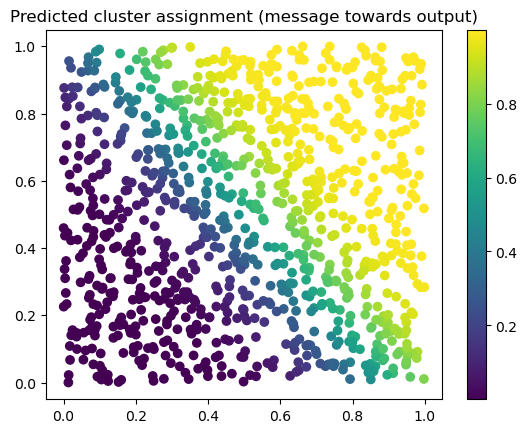

In [12]:
plt.figure()
plt.scatter(data_x_grid[:,1], data_x_grid[:,2], c=mean.(mout))
plt.title("Predicted cluster assignment (message towards output)")
plt.colorbar();